# Zadanie: Implementacja i Trenowanie VAE na zbiorze MNIST-100

Cel:

Celem zadania jest zaimplementowanie i przeszkolenie Variational Autoencoder (VAE) na zbiorze danych MNIST-100. Zadanie to pozwoli na zrozumienie podstawowych mechanizmów stojących za autoenkoderami wariacyjnymi oraz ich zastosowanie w generowaniu nowych, realistycznych obrazów mody. Zadania szczegółowe:

Przygotowanie Danych:
1. Wczytaj zbiór danych MNIST 100 korzystając z dostępnych bibliotek, takich jak TensorFlow.

Implementacja VAE:
1. Zaimplementuj architekturę VAE, która zawiera enkoder, dekoder oraz mechanizm reparametryzacji.
2. Enkoder powinien mapować obrazy wejściowe na rozkład prawdopodobieństwa w przestrzeni latentnej.
3. Dekoder powinien odtwarzać obrazy z próbek pobranych z przestrzeni latentnej.

Trenowanie Modelu:
1. Przetrenuj model na zbiorze. 
2. Eksperymentuj z różnymi rozmiarami przestrzeni latentnej, szybkościami uczenia się i rozmiarami partii, aby znaleźć optymalne ustawienia.

Ewaluacja i Wizualizacja:
1. Po przeszkoleniu modelu użyj dekodera do generowania nowych obrazów z próbek pobranych z przestrzeni latentnej.
2. Wizualizuj oryginalne obrazy testowe i ich odtworzenia, aby ocenić jakość rekonstrukcji.
3. Wizualizuj próbki z przestrzeni latentnej w formie obrazów, aby zobaczyć, jakie cechy zostały nauczone przez model.

Kryteria Oceny:
1. Poprawność implementacji VAE, w tym enkodera, dekodera.
2. Jakość rekonstrukcji obrazów oraz interesujące cechy wygenerowane przez model w przestrzeni latentnej.
3. Kreatywność w eksploracji różnych konfiguracji modelu i interpretacji wyników.

Dodatkowe Wskazówki:
1. Zaczynając, warto skorzystać z prostych architektur sieci neuronowych, takich jak sieci w pełni połączone lub proste sieci konwolucyjne.
2. Dokładnie dokumentuj wszelkie eksperymenty i obserwacje, aby móc wyciągać wnioski i dostosowywać podejście.
3. Korzystając z bibliotek takich jak TensorFlow, można znaleźć wiele przykładowych implementacji VAE, które mogą posłużyć jako punkt wyjścia.

In [1]:
import numpy as np

# Loading data from the 'mnist_compressed.npz' file
data = np.load('/kaggle/input/mnist100/mnist_compressed.npz')

# Reading variables containing the data
X_test, y_test, X_train, y_train =  data['test_images'], data['test_labels'], data['train_images'], data['train_labels']

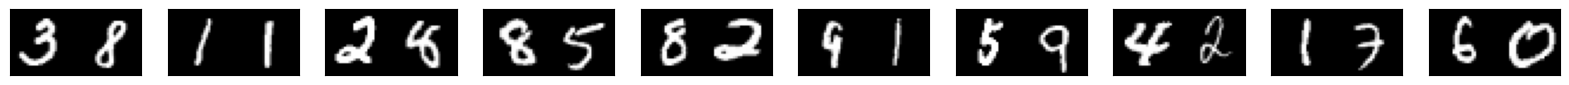

In [2]:
import matplotlib.pyplot as plt

n = 10

plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [6]:
mnist_images = X_test/255
mnist_images.shape

(10000, 28, 56)

In [12]:
y_test

array([53, 38, 11, ..., 27, 94, 64])

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
import pandas as pd 
latent_dim = 2  # Wymiar przestrzeni ukrytej

encoder_inputs = layers.Input(shape=(28, 56, 1))
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
   z_mean, z_log_var = args
   batch = K.shape(z_mean)[0]
   dim = K.int_shape(z_mean)[1]
   epsilon = K.random_normal(shape=(batch, dim))
   return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

2024-03-11 09:05:05.913573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 09:05:05.913689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 09:05:06.079618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 56, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 28,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 14,     │     73,856 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,605,760 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,680,772 (6.41 MB)

 Trainable params: 1,680,772 (6.41 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 14 * 128, activation='relu')(latent_inputs)
x = layers.Reshape((7, 14, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12544)          │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 28, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 56, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 56, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,585 (1014.00 KB)

 Trainable params: 259,585 (1014.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
class VAE(Model):
   def __init__(self, encoder, decoder, **kwargs):
       super(VAE, self).__init__(**kwargs)
       self.encoder = encoder
       self.decoder = decoder

   def call(self, inputs):
       z_mean, z_log_var, z = self.encoder(inputs)
       reconstructed = self.decoder(z)
       kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
       self.add_loss(K.mean(kl_loss) / 784.0)
       return reconstructed

In [15]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss='mse')

vae.fit(mnist_images, mnist_images, epochs=100, batch_size=64)

Epoch 1/100
  7/157 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2249

I0000 00:00:1710148074.516100     144 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710148074.536060     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710148074.539091     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.1072
Epoch 2/100
 11/157 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0672

W0000 00:00:1710148079.558974     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0661
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0637
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0631
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0625
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0622
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0617
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0619
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0614
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0613
Epoch 11/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0613
Epoch 12/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0609
Epoch 13/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0609
Epoch 14/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0606
Epoch 15/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0602
Epoch 16/100
157/157 ━━━━━━━━━━━━━━━━━━━

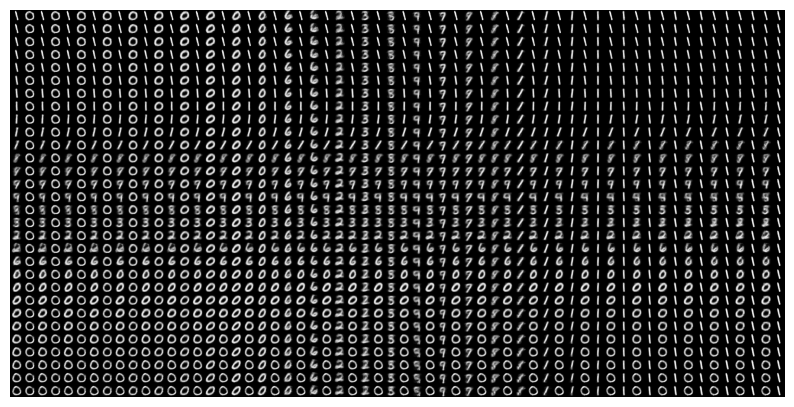

In [21]:
import matplotlib.pyplot as plt

n = 30  # Liczba cyfr do wygenerowania
figure = np.zeros((28 * n, 56 * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
   for j, xi in enumerate(grid_y):
       z_sample = np.array([[xi, yi]])
       x_decoded = decoder.predict(z_sample, verbose=0)
       digit = x_decoded[0].reshape(28, 56)
       figure[i * 28: (i + 1) * 28,
              j * 56: (j + 1) * 56] = digit

plt.figure(figsize=(10, 20))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

### Zadanie autoenkoder

Zadanie: Oczyszczanie i Rekonstrukcja Obrazów za pomocą Autoenkodera

Cel zadania: Twoim zadaniem jest trenowanie autoenkodera w celu oczyszczenia i rekonstrukcji zaburzonych obrazów znaków migowych. Wykorzystasz zbiór danych zawierający obrazy oraz ich odpowiednie zaszumione wersje.

Opis zadania:

* Podział danych: Podziel dane na zbiór treningowy i testowy, wykorzystując dostępne narzędzia takie jak train_test_split.

* Dodanie szumu: Wygeneruj zaburzone wersje obrazów treningowych i testowych, dodając szum. W przykładzie użyto x_train_noisy i x_test_noisy.

* Model autoenkodera: Zbuduj model autoenkodera w oparciu o Keras. Model powinien zawierać warstwy konwolucyjne do oczyszczania obrazów. Zadaniem modelu jest przewidzenie oryginalnych, niezaburzonych obrazów na podstawie ich zaburzonych wersji.

* Trening modelu: Trenuj autoenkoder na danych treningowych (x_train_noisy) w celu nauczenia go oczyszczania obrazów. Skorzystaj z odpowiednich hiperparametrów, takich jak liczba epok, rozmiar batcha itp.

* Ewaluacja modelu: Po treningu, oceniaj model na danych testowych (x_test_noisy) i oblicz jakość oczyszczania obrazów.

* Wizualizacja wyników: Wykorzystaj model do rekonstrukcji obrazów i wyświetlenia oryginalnych i oczyszczonych wersji w celu oceny jakości modelu.

Uwagi:

* Ewaluacja modelu będzie polegać na porównaniu rekonstruowanych obrazów z ich oryginalnymi wersjami.
* Możesz dostosować kod i eksperymentować z architekturą autoenkodera oraz parametrami modelu, takimi jak funkcja straty i optymalizator, aby uzyskać najlepsze wyniki.
* Możesz także rozważyć inne techniki poprawy jakości obrazów, takie jak zastosowanie sieci generatywnych.
* To zadanie koncentruje się na uczeniu maszynowym w kontekście przetwarzania obrazów, w szczególności na oczyszczaniu i rekonstrukcji obrazów za pomocą autoenkodera.

In [35]:
X_train.max()

255

In [36]:
noise_factor = 0.2
x_train_noisy = X_train/255 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_test_noisy = X_test/255 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train=X_train/255
x_test=X_test/255

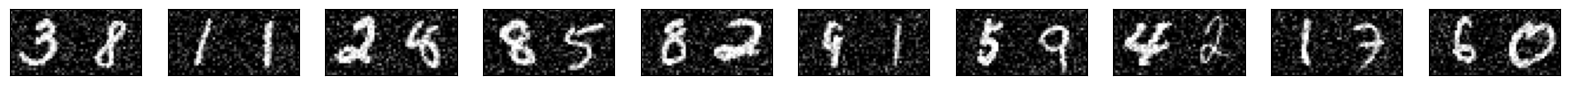

In [38]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
import matplotlib.pyplot as plt

n = 10

plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [40]:
from keras.layers import Conv2D, MaxPooling2D, Conv2D, UpSampling2D
from keras import Input, Model

input_img = Input(shape=(28, 56, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 14, 32)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,epochs=10,batch_size=64,shuffle=True,validation_data=(x_test_noisy, x_test))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.1328 - val_loss: 0.0741
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0741 - val_loss: 0.0716
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0719 - val_loss: 0.0707
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0709 - val_loss: 0.0700
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0703 - val_loss: 0.0695
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0700 - val_loss: 0.0692
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0697 - val_loss: 0.0691
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0694 - val_loss: 0.0688
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0692 - val_loss: 0.0687
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0690 - val_loss: 0.0686


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


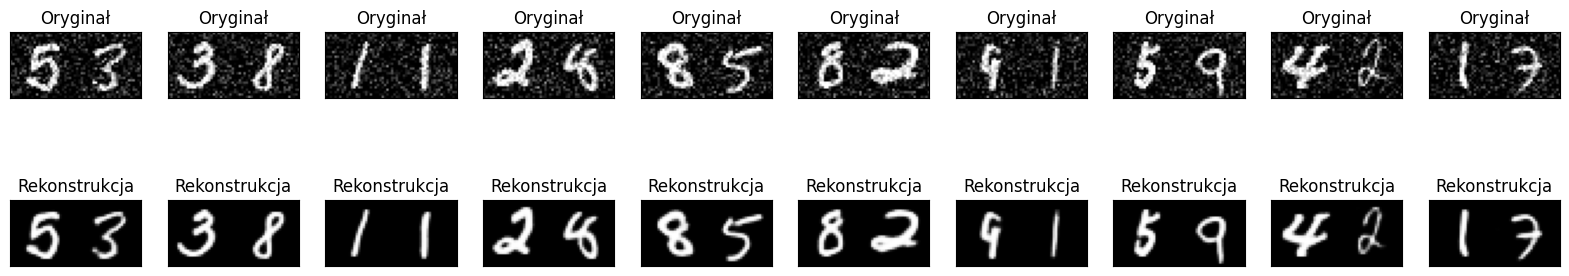

In [41]:
import matplotlib.pyplot as plt

# Odtworzenie obrazów z zestawu testowego
decoded_images = autoencoder.predict(x_test_noisy)

# Wybór kilku przykładów do wizualizacji
n = 10  # Wybierz liczbę przykładów do wyświetlenia
plt.figure(figsize=(20, 4))
for i in range(n):
    # Obraz oryginalny
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 56))
    plt.title("Oryginał")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Rekonstrukcja
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(28, 56))
    plt.title("Rekonstrukcja")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Zadanie prostsze: Analiza fake newsów na podstawie Headline z PositionalEncoding

Twoim zadaniem jest stworzenie modelu sieci neuronowej, który będzie klasyfikować tweety na podstawie Headline. W danych mamy dostarczone tytuły artykułów oraz etykiety. Kroki, które musisz podjąć:

Przygotowanie danych: Dane zostały wczytane z pliku CSV. Teksty znajdują się w kolumnach title, a etykiety w kolumnie "class". Teksty oraz etykiety są przygotowane do dalszej obróbki.

1. Tokenizacja tekstu: Teksty powinny być tokenizowane za pomocą Tokenizer, a następnie przekształcane na sekwencje liczb. Jest to niezbędne, aby można było używać ich jako danych wejściowych do modelu sieci neuronowej.

Zbuduj model sieci neuronowej: Model sieci rekurencyjnej zdefiniuj w kodzie i przykładowo niech składa się z następujących warstw:

1. Warstwa wejściowa: Przyjmuje sekwencje tokenów o długości określonej przez max_sequence_length.
2. Warstwa Embedding: Mapuje tokeny na wektory o wymiarze embed_dim (100 w tym przypadku), co pozwala na reprezentację słów jako gęstych wektorów cech.
3. Warstwa MultiHeadAttention: Implementuje mechanizm uwagi, który pozwala modelowi skupić się na różnych częściach sekwencji wejściowej, co jest szczególnie przydatne w przetwarzaniu języka naturalnego.
4. GlobalAveragePooling1D: Agreguje informacje z różnych części sekwencji, redukując wymiarowość danych i przygotowując je do procesu klasyfikacji.
5. Warstwa Dense (wyjściowa): Z funkcją aktywacji softmax, generuje dystrybucję prawdopodobieństwa dla dwóch możliwych klas sentymentu, umożliwiając klasyfikację.
6. Kompilacja modelu: Model jest kompilowany z optymalizatorem Adam, funkcją straty "categorical_crossentropy" (odpowiednia do klasyfikacji wieloklasowej) oraz metryką "accuracy".

Trenowanie modelu: Model jest trenowany na danych tweetów przez 5 epok, z wsadem o rozmiarze 32. Wynik trenowania jest oceniany na zbiorze walidacyjnym.

Twoim zadaniem jest uzupełnienie kodu i dostosowanie parametrów modelu oraz trenowania, aby uzyskać jak najlepsze wyniki w zadaniu analizy fake newsów na podstawie tytułów. Możesz eksperymentować z parametrami, takimi jak liczba epok trenowania, rozmiar wsadu (batch size).

In [42]:
import pandas as pd 

df = pd.read_csv('/kaggle/input/fake-news-detection/data.csv')
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [51]:
X_train = df['Headline'].to_numpy()
y_train = df['Label'].to_numpy()

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenizacja tekstu
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(sequences, y, test_size=0.3, random_state=42)

max_sequence_length = max(len(seq) for seq in X)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_val = pad_sequences(X_val, maxlen=max_sequence_length)

In [48]:
from tensorflow.keras.layers import Layer, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Input

class PositionalEncoding(Layer):
   def __init__(self, position, d_model):
       super(PositionalEncoding, self).__init__()
       self.pos_encoding = self.positional_encoding(position, d_model)

   def get_angles(self, position, i, d_model):
       angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
       return position * angles

   def positional_encoding(self, position, d_model):
       angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                    np.arange(d_model)[np.newaxis, :],
                                    d_model)
       # Aplikuj sinus do indeksów parzystych w macierzy; 2i
       angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
       # Aplikuj cosinus do indeksów nieparzystych w macierzy; 2i+1
       angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
       pos_encoding = angle_rads[np.newaxis, ...]
       return tf.cast(pos_encoding, dtype=tf.float32)

   def call(self, inputs):
       return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [49]:
from tensorflow.keras.layers import Layer, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Input

from keras import layers
class TokenAndPositionEmbedding(layers.Layer):
   def __init__(self, maxlen, vocab_size, embed_dim):
       super().__init__()
       self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
       self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

   def call(self, x):
       # Obliczanie długości sekwencji
       maxlen = tf.shape(x)[-1]
       # Generowanie pozycji dla każdego tokenu w sekwencji
       positions = tf.range(start=0, limit=maxlen, delta=1)
       # Uzyskanie pozycyjnego embedding
       positions = self.pos_emb(positions)
       # Uzyskanie tlenowego embedding
       x = self.token_emb(x)
       # Dodanie pozycyjnego embedding do tlenowego embedding
       return x + positions

In [54]:
X_train.shape

(2806, 653)

In [60]:
y_train.max()

1

In [66]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, GlobalAveragePooling1D, Dense
import numpy as np
embed_dim = 100  # Wymiar wektora embeddingowego
num_heads = 4  # Liczba "głowic" w warstwie Multi-Head Attention
vocab_size = 10000  # Rozmiar słownika

inputs = Input(shape=(max_sequence_length,))
positional_layer=TokenAndPositionEmbedding(max_sequence_length,vocab_size, embed_dim)(inputs)
#positional_layer=PositionalEncoding(vocab_size, embed_dim)(inputs),
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(positional_layer, positional_layer)
global_average = GlobalAveragePooling1D()(attention_output)
global_average= Dropout(0.4) (global_average)
outputs = Dense(1, activation='sigmoid')(global_average)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=6, batch_size=32, validation_split=0.1, verbose=1, shuffle=True)

Epoch 1/6
 3/79 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5260 - loss: 0.7612

W0000 00:00:1710151742.248191     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5400 - loss: 1.3538

W0000 00:00:1710151748.130137     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710151748.743110     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.5407 - loss: 1.3480 - val_accuracy: 0.6370 - val_loss: 0.6284
Epoch 2/6
 3/79 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8698 - loss: 0.3668

W0000 00:00:1710151749.220926     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8450 - loss: 0.4006 - val_accuracy: 0.7367 - val_loss: 0.5808
Epoch 3/6
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8864 - loss: 0.2936 - val_accuracy: 0.7580 - val_loss: 0.5932
Epoch 4/6
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9425 - loss: 0.1750 - val_accuracy: 0.7544 - val_loss: 0.6004
Epoch 5/6
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9833 - loss: 0.0533 - val_accuracy: 0.7509 - val_loss: 0.8131
Epoch 6/6
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9785 - loss: 0.0751 - val_accuracy: 0.7367 - val_loss: 1.1516


#### Klasyfikacja kwiatów z RESNETEM
Ten zestaw danych zawiera 5 różnych rodzajów kwiatów. Twoim zadaniem jest zbudowanie modelu uczenia maszynowego lub głębokiego uczenia, który będzie w stanie klasyfikować te obrazy jako kwiaty. Oto klasy, które są dostępne:

* daisy
* dandelion
* rose
* sunflower
* tulip

Twoim zadaniem jest stworzenie modelu sieci neuronowej, który będzie klasyfikować obrazy w kategorie kwiatów np. tulipan itp. W tym celu wykorzystaj model ResNet50, który został wstępnie przeszkolony na szerokim zbiorze danych.

Kroki, które musisz podjąć:

1. Załadowanie danych: Dane treningowe zostały już przygotowane w formie generatorów za pomocą biblioteki ImageDataGenerator. Generator treningowy zawiera obrazy treningowe, a generator walidacyjny zawiera obrazy walidacyjne. Obrazy są przeskalowane do rozmiaru (224, 224) i podzielone na klasy.

2. Model ResNet50: W kodzie załaduj model ResNet50, który jest wstępnie przeszkolony na zestawie danych ImageNet. Model ten ma zamrożone wagi wszystkich warstw.

3. Warstwy klasyfikacji: Do modelu ResNet50 dodano warstwy klasyfikacji. Jest to warstwa GlobalAveragePooling2D i warstwa Dense, która wykorzystuje funkcję aktywacji softmax. Model ten jest przystosowany do zadania klasyfikacji.

4. Kompilacja modelu: Model jest skompilowany z optymalizatorem Adam, funkcją straty "categorical_crossentropy" (odpowiednia do klasyfikacji wieloklasowej), oraz metryką "accuracy".

5. Trenowanie modelu: Model jest trenowany na danych treningowych przez jedną epokę. Wynik trenowania jest wyświetlany na konsoli.

Twoim zadaniem jest uzupełnienie tego kodu o brakujące elementy, takie jak liczba epok trenowania, odblokowanie warstw modelu ResNet50 oraz dostosowanie modelu do odpowiedniego rodzaju klasyfikacji (wieloklasowej). Następnie możesz dostosować parametry trenowania, takie jak liczba epok czy wielkość wsadu (batch size), aby osiągnąć jak najlepsze wyniki w zadaniu klasyfikacji.

In [68]:
# Ustawienie ścieżki do katalogu z danymi
# Rozwiązanie
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Definicja generatora obrazów
datagen = ImageDataGenerator(
    rescale=1.0/255, # Przeskalowanie wartości pikseli do zakresu [0, 1]
    validation_split=0.2 # Procent danych przeznaczonych na zbiór walidacyjny
)

# Wczytanie danych treningowych
train_generator = datagen.flow_from_directory(
    '/kaggle/input/flowers-dataset/train',
    target_size=(224, 224), # Rozmiar docelowy obrazów
    batch_size=32, # Rozmiar wsadu
    class_mode='categorical', # Rodzaj klasyfikacji (binary lub categorical)
    subset='training' # Ustawienie dla danych treningowych
)


Found 2198 images belonging to 5 classes.


In [67]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, GlobalAveragePooling2D, AveragePooling2D, Flatten

In [73]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Adding new classification layers
model = Sequential([   base_model,   GlobalAveragePooling2D(),   Dense(5, activation='softmax')])
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=100, verbose=1)


Epoch 1/100
 2/69 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.2422 - loss: 1.9471 

W0000 00:00:1710152235.571417     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/69 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.2243 - loss: 2.0222

W0000 00:00:1710152241.292670     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.2612 - loss: 1.8765
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.3582 - loss: 1.4993
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.4307 - loss: 1.3992
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.4567 - loss: 1.3575
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.4407 - loss: 1.3388
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.4315 - loss: 1.3975
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.4790 - loss: 1.2895
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.4814 - loss: 1.2829
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.5314 - loss: 1.2374
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.4934 - loss: 1.2781
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.5178 - loss: 1.2380
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accur

Found 0 images belonging to 0 classes.
